# Getting the Envirnment Setup

In [1]:
!pip install tensorflow-gpu==1.14

In [2]:
# Importing all of the necessary libraries

import tensorflow as tf

import numpy as np

import xml.etree.ElementTree as ET

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import keras
from keras import models
from keras import layers
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

from scipy import fftpack

import sklearn.preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

from seaborn import heatmap


Using TensorFlow backend.


# Defining Functions

In [3]:
# Functions for statistics to judge the effectiveness of the models

def modelRecall(trueResult, predictedResult):
    "Calculates recall (true positives/all positives)"

    truePos = keras.backend.sum(keras.backend.round(keras.backend.clip(trueResult * predictedResult, 0, 1)))
    allPositives = keras.backend.sum(keras.backend.round(keras.backend.clip(trueResult, 0, 1)))
    return truePos/(allPositives + keras.backend.epsilon())

def modelPrecision(trueResult, predictedResult):
    "Calculates precision (true positives/predicted positives)"

    truePos = keras.backend.sum(keras.backend.round(keras.backend.clip(trueResult * predictedResult, 0, 1)))
    predPositives = keras.backend.sum(keras.backend.round(keras.backend.clip(predictedResult, 0, 1)))
    return truePos/(predPositives + keras.backend.epsilon())

def modelF1Score(trueResult, predictedResult):
    "Calculates F1-Score (2*((precision*recall)/(precision+recall)))"

    precisionResult = modelPrecision(trueResult, predictedResult)
    recallResult = modelRecall(trueResult, predictedResult)
    return 2 * ((precisionResult*recallResult)/(precisionResult+recallResult+keras.backend.epsilon()))

def modelAccuracy(model, test_data, test_label):
    score = model.evaluate(test_data, test_label, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return

# Function to plot training and validation, as well as training and validation accuracies

def plotResults(model_history):
    
    # Plot training & validation
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Epoch-Loss Plot')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    return

# Function for fourier transform

def fourierTransformer(trainData, minFreq = np.nan, maxFreq = np.nan, lengthOfRecording = np.nan, removeDCOffset = True):
  """
  Returns the fourier transform for a gived dataset. 
  :param trainData: Array of time domain datasets, with each row being a differet dataset. 
  :param minFreq: The lower bound of frequencies you want returned. Default = np.nan (no cutoff)
  :param maxFreq: The upper bound of frequencies you want returned. Default = np.nan (no cutoff)
  :param lengthOfRecording: Length of recording in seconds. Must be provided if minFreq or maxFreq are provided.
  :param removeDCOffset: Whether you want remove the 0 frequency data (DC Offset). Default = True
  """
  
  output = np.zeros(trainData.shape)

  for i in range(trainData.shape[0]):
    output[i, :] = fftpack.fft(trainData[i, :]) 
  
  if not np.isnan(maxFreq) or not np.isnan(minFreq):
    assert not np.isnan(lengthOfRecording), "lengthOfRecording must be defined if minFreq or maxFreq are defined"
    fftFrequencies = fftpack.fftfreq(trainData.shape[1] * 2, d = lengthOfRecording/trainData.shape[1])

  if np.isnan(minFreq):
    minLim = int(removeDCOffset)
  else:
    minLim = np.where(fftFrequencies == minFreq)[0][0]

  if np.isnan(maxFreq):
    maxLim = output.shape[1]//2
  else:
    maxLim = np.where(fftFrequencies == maxFreq)[0][0]

  return np.abs(output[:, minLim:maxLim])

# Loading the Data Files

In [4]:
'''
Loading the different data sets to be used with the models
These data sets have already been preprocessed and prepared for the models
Two different data sets are used
The first data set is the above-in data set, where the classifier is either above the brain or in the brain
This simplifies the data the models will use to make sure that they can properly classify a simple binary classification problem

The second data set which is the multi-region set uses all 22 of the different brain regions for classification
and represents the actual classification problem

Each of the different data sets has data for training, testing, and validation
Because of this, there is no need for a train_test_split
'''

train_data_above_in = np.load('first_5m_train_input_3s_lfp_above_in_2recordings.npy')
test_data_above_in = np.load('first_5m_test_input_3s_lfp_above_in_2recordings.npy')
val_data_above_in = np.load('first_5m_val_input_3s_lfp_above_in_2recordings.npy')
train_label_above_in = np.load('first_5m_train_labels_3s_lfp_above_in_2recordings.npy')
test_label_above_in = np.load('first_5m_test_labels_3s_lfp_above_in_2recordings.npy')
val_label_above_in = np.load('first_5m_val_labels_3s_lfp_above_in_2recordings.npy')

train_data_multi = np.load('first_5m_train_input_3s_lfp_multi_region_4recordings.npy')
test_data_multi = np.load('first_5m_test_input_3s_lfp_multi_region_4recordings.npy')
val_data_multi = np.load('first_5m_val_input_3s_lfp_multi_region_4recordings.npy')
train_label_multi = np.load('first_5m_train_labels_3s_lfp_multi_region_4recordings.npy')
test_label_multi = np.load('first_5m_test_labels_3s_lfp_multi_region_4recordings.npy')
val_label_multi = np.load('first_5m_val_labels_3s_lfp_multi_region_4recordings.npy')

In [5]:
# Expanding the input data for the CNNs, which requires 3-dimensional data sets

print(train_data_multi.shape)
print(test_data_multi.shape)
print(val_data_multi.shape)

train_data_above_in = np.expand_dims(train_data_above_in, axis=2)
test_data_above_in = np.expand_dims(test_data_above_in, axis=2)
val_data_above_in = np.expand_dims(val_data_above_in, axis=2)

train_data_multi = np.expand_dims(train_data_multi, axis=2)
test_data_multi = np.expand_dims(test_data_multi, axis=2)
val_data_multi = np.expand_dims(val_data_multi, axis=2)

print(train_data_multi.shape)
print(test_data_multi.shape)
print(val_data_multi.shape)

(73980, 7500)
(24660, 7500)
(24660, 7500)
(73980, 7500, 1)
(24660, 7500, 1)
(24660, 7500, 1)


# Building and Testing the Neural Networks

In [29]:
# Model 1: Initial model on the simple data set
opt = keras.optimizers.adam(lr=0.01)

CNN_above_in_1 = models.Sequential()
CNN_above_in_1.add(layers.Conv1D(filters=6, kernel_size=300, activation='relu', input_shape=(7500,1)))
CNN_above_in_1.add(layers.Conv1D(filters=4, kernel_size=4, activation='relu'))
CNN_above_in_1.add(layers.Dropout(0.5))
CNN_above_in_1.add(layers.MaxPooling1D(pool_size=2))
CNN_above_in_1.add(layers.Flatten())
CNN_above_in_1.add(layers.Dense(44, activation='relu'))
CNN_above_in_1.add(layers.Dense(22, activation='softmax'))
CNN_above_in_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
'''
#To save the model weights to a hard drive

checkpoint_filepath = '/content/drive/My Drive/CSCI_5391/weights_best.hdf5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
'''

In [30]:
CNN_above_in_1_history = CNN_above_in_1.fit(train_data_above_in, train_label_above_in, 
                   validation_data=(val_data_above_in ,val_label_above_in),
                   epochs=20, batch_size=256)

Train on 4800 samples, validate on 1600 samples
Epoch 1/20
4800/4800 [==============================] - 37s 8ms/step - loss: 0.7247 - accuracy: 0.9513 - val_loss: 0.6727 - val_accuracy: 0.9561
Epoch 2/20
4800/4800 [==============================] - 32s 7ms/step - loss: 0.7139 - accuracy: 0.9536 - val_loss: 0.6727 - val_accuracy: 0.9561
Epoch 3/20
4800/4800 [==============================] - 32s 7ms/step - loss: 0.7139 - accuracy: 0.9536 - val_loss: 0.6727 - val_accuracy: 0.9561
Epoch 4/20
4800/4800 [==============================] - 32s 7ms/step - loss: 0.7139 - accuracy: 0.9536 - val_loss: 0.6727 - val_accuracy: 0.9561
Epoch 5/20
4800/4800 [==============================] - 32s 7ms/step - loss: 0.7139 - accuracy: 0.9536 - val_loss: 0.6727 - val_accuracy: 0.9561
Epoch 6/20
4800/4800 [==============================] - 32s 7ms/step - loss: 0.7139 - accuracy: 0.9536 - val_loss: 0.6727 - val_accuracy: 0.9561
Epoch 7/20
4800/4800 [==============================] - 33s 7ms/step - loss: 0.713

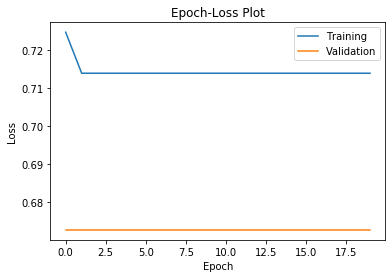

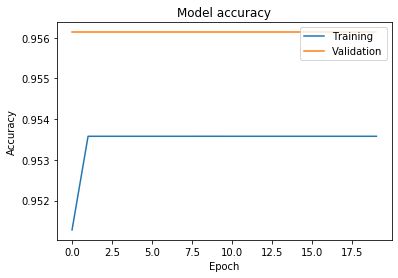

Test loss: 0.677097817659378
Test accuracy: 0.9558525085449219


In [31]:
plotResults(CNN_above_in_1_history)
modelAccuracy(CNN_above_in_1, test_data_above_in, test_label_above_in)

As is to be expected for this type of simple binary classification data, the model quickly reaches 95.13% accuracy in the first epoch, and levels off around 95.36% accuracy. This simple experiment shows that this data can be classified by a 1D CNN. To further test this model, and other models, more experiments are performed only utilizing the multi-categorical data. This data has 22 distinct classifications.

In [10]:
# Model 1 on the harder, multi-region data

CNN_multi_1 = models.Sequential()
CNN_multi_1.add(layers.Conv1D(filters=6, kernel_size=300, activation='relu', input_shape=(7500,1)))
CNN_multi_1.add(layers.Conv1D(filters=4, kernel_size=4, activation='relu'))
CNN_multi_1.add(layers.Dropout(0.5))
CNN_multi_1.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_1.add(layers.Flatten())
CNN_multi_1.add(layers.Dense(44, activation='relu'))
CNN_multi_1.add(layers.Dense(22, activation='softmax'))
CNN_multi_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
CNN_multi_1_history = CNN_multi_1.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi ,val_label_multi),
                   epochs=20, batch_size=256)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 484s 7ms/step - loss: 3.1919 - accuracy: 0.2413 - val_loss: 2.2489 - val_accuracy: 0.3367
Epoch 2/20
73980/73980 [==============================] - 490s 7ms/step - loss: 1.9382 - accuracy: 0.4003 - val_loss: 1.6299 - val_accuracy: 0.4984
Epoch 3/20
73980/73980 [==============================] - 518s 7ms/step - loss: 1.4165 - accuracy: 0.5464 - val_loss: 1.1931 - val_accuracy: 0.6262
Epoch 4/20
73980/73980 [==============================] - 498s 7ms/step - loss: 1.0845 - accuracy: 0.6476 - val_loss: 1.0816 - val_accuracy: 0.6545
Epoch 5/20
73980/73980 [==============================] - 507s 7ms/step - loss: 0.8485 - accuracy: 0.7249 - val_loss: 0.7375 - val_accuracy: 0.7695
Epoch 6/20
73980/73980 [==============================] - 500s 7ms/step - loss: 0.6750 - accuracy: 0.7802 - val_loss: 0.6584 - val_accuracy: 0.7976
Epoch 7/20
73980/73980 [==============================] - 535s

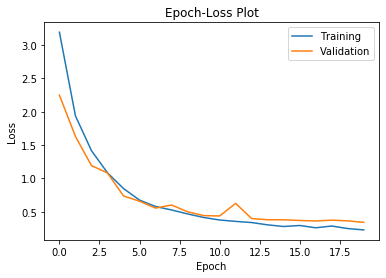

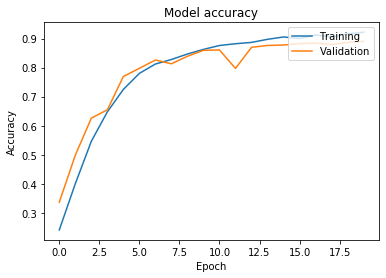

Test loss: 0.35985241901168763
Test accuracy: 0.8876317739486694


In [12]:
plotResults(CNN_multi_1_history)
modelAccuracy(CNN_multi_1, test_data_multi, test_label_multi)

A model showing good results over 20 epochs, leveling off around 95% accuracy.

In [13]:
'''
Model2: Another model for the above-in data
For the convolutional layers: more filters, but smaller kernel sizes.
As well as a larger intermediate dense layer
'''

CNN_above_in_2 = models.Sequential()
CNN_above_in_2.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(7500,1)))
CNN_above_in_2.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
CNN_above_in_2.add(layers.Dropout(0.5))
CNN_above_in_2.add(layers.MaxPooling1D(pool_size=2))
CNN_above_in_2.add(layers.Flatten())
CNN_above_in_2.add(layers.Dense(50, activation='relu'))
CNN_above_in_2.add(layers.Dense(22, activation='softmax'))
CNN_above_in_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
CNN_above_in_2_history = CNN_above_in_2.fit(train_data_above_in, train_label_above_in, 
                   validation_data=(val_data_above_in ,val_label_above_in),
                   epochs=20, batch_size=256)

Train on 4800 samples, validate on 1600 samples
Epoch 1/20
4800/4800 [==============================] - 51s 11ms/step - loss: 0.7468 - accuracy: 0.9504 - val_loss: 0.7215 - val_accuracy: 0.9530
Epoch 2/20
4800/4800 [==============================] - 51s 11ms/step - loss: 0.6842 - accuracy: 0.9555 - val_loss: 0.7215 - val_accuracy: 0.9530
Epoch 3/20
4800/4800 [==============================] - 51s 11ms/step - loss: 0.6842 - accuracy: 0.9555 - val_loss: 0.7215 - val_accuracy: 0.9530
Epoch 4/20
4800/4800 [==============================] - 51s 11ms/step - loss: 0.6842 - accuracy: 0.9555 - val_loss: 0.7215 - val_accuracy: 0.9530
Epoch 5/20
4800/4800 [==============================] - 51s 11ms/step - loss: 0.6842 - accuracy: 0.9555 - val_loss: 0.7215 - val_accuracy: 0.9530
Epoch 6/20
4800/4800 [==============================] - 51s 11ms/step - loss: 0.6842 - accuracy: 0.9555 - val_loss: 0.7215 - val_accuracy: 0.9530
Epoch 7/20
4800/4800 [==============================] - 51s 11ms/step - loss

In [22]:
# Model 2 on the multi-region data set

opt = keras.optimizers.adam(lr=0.008)

CNN_multi_2 = models.Sequential()
CNN_multi_2.add(layers.Conv1D(filters=16, kernel_size=4, activation='relu', input_shape=(7500,1)))
CNN_multi_2.add(layers.Conv1D(filters=16, kernel_size=4, activation='relu'))
CNN_multi_2.add(layers.Dropout(0.5))
CNN_multi_2.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_2.add(layers.Flatten())
CNN_multi_2.add(layers.Dense(50, activation='relu'))
CNN_multi_2.add(layers.Dense(22, activation='softmax'))
CNN_multi_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
CNN_multi_2_history = CNN_multi_2.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi ,test_label_multi),
                   epochs=20, batch_size=128)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 409s 6ms/step - loss: 31.3978 - accuracy: 0.1276 - val_loss: 2.8140 - val_accuracy: 0.1264
Epoch 2/20
73980/73980 [==============================] - 405s 5ms/step - loss: 2.7286 - accuracy: 0.1474 - val_loss: 2.6680 - val_accuracy: 0.1485
Epoch 3/20
73980/73980 [==============================] - 407s 5ms/step - loss: 2.6261 - accuracy: 0.1478 - val_loss: 2.6029 - val_accuracy: 0.1485
Epoch 4/20
73980/73980 [==============================] - 404s 5ms/step - loss: 2.5797 - accuracy: 0.1478 - val_loss: 2.5714 - val_accuracy: 0.1484
Epoch 5/20
73980/73980 [==============================] - 396s 5ms/step - loss: 2.5561 - accuracy: 0.1478 - val_loss: 2.5543 - val_accuracy: 0.1485
Epoch 6/20
73980/73980 [==============================] - 403s 5ms/step - loss: 2.5424 - accuracy: 0.1478 - val_loss: 2.5437 - val_accuracy: 0.1485
Epoch 7/20
73980/73980 [==============================] - 401

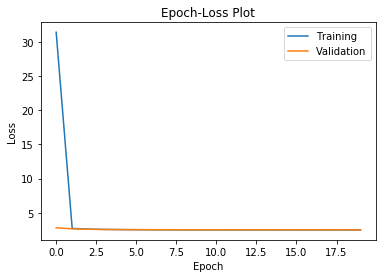

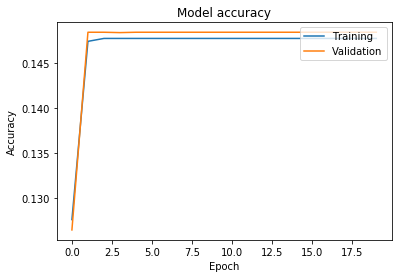

Test loss: 2.514040122105644
Test accuracy: 0.1484590470790863


In [24]:
plotResults(CNN_multi_2_history)
modelAccuracy(CNN_multi_2, test_data_multi, test_label_multi)

This model reaches a plateau of 14.78% accuracy. Slight changes were made to the model such as learning rate, number of epochs, and batch size but there was no change in accuracy. This points to the fact that the base architecture of the model is inefficient at learning the classification of the data.

In [22]:
# Model 3
# Variation of Model 1
# Changing the filter and kernel sizes

CNN_multi_3 = models.Sequential()
CNN_multi_3.add(layers.Conv1D(filters=6, kernel_size=50, activation='relu', input_shape=(7500,1)))
CNN_multi_3.add(layers.Conv1D(filters=4, kernel_size=25, activation='relu'))
CNN_multi_3.add(layers.Dropout(0.5))
CNN_multi_3.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_3.add(layers.Flatten())
CNN_multi_3.add(layers.Dense(44, activation='relu'))
CNN_multi_3.add(layers.Dense(22, activation='softmax'))
CNN_multi_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
CNN_multi_3_history = CNN_multi_3.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi ,test_label_multi),
                   epochs=20, batch_size=256)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 372s 5ms/step - loss: 2.8897 - accuracy: 0.3941 - val_loss: 4.1116 - val_accuracy: 0.1012
Epoch 2/20
73980/73980 [==============================] - 374s 5ms/step - loss: 0.9085 - accuracy: 0.7114 - val_loss: 6.4880 - val_accuracy: 0.0981
Epoch 3/20
73980/73980 [==============================] - 367s 5ms/step - loss: 0.5964 - accuracy: 0.8052 - val_loss: 7.5784 - val_accuracy: 0.0970
Epoch 4/20
73980/73980 [==============================] - 351s 5ms/step - loss: 0.4743 - accuracy: 0.8451 - val_loss: 8.0884 - val_accuracy: 0.0975
Epoch 5/20
73980/73980 [==============================] - 354s 5ms/step - loss: 0.3961 - accuracy: 0.8694 - val_loss: 8.3467 - val_accuracy: 0.0976
Epoch 6/20
73980/73980 [==============================] - 344s 5ms/step - loss: 0.3499 - accuracy: 0.8855 - val_loss: 10.4220 - val_accuracy: 0.0962
Epoch 7/20
73980/73980 [==============================] - 347

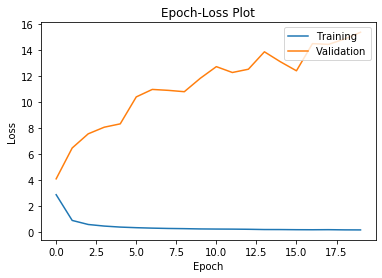

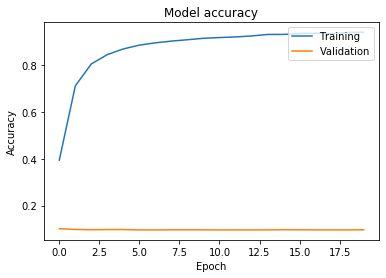

Test loss: 0.3286457807091514
Test accuracy: 0.899756669998169


In [24]:
plotResults(CNN_multi_3_history)
modelAccuracy(CNN_multi_3, test_data_multi, test_label_multi)

This model performs very well on the training data, and only slightly worse on the test data. The accuracy for the validation data points to the fact that the model may be over training on the training data, or that the validation data is skewed in some way. For instance this could be due to not enough validation samples, or that the validation data is over represented in a specific category.

In [25]:
'''
Model 4
Similar to the above model but slightly refined
Uses a SGD optimizer where learning rate can be adjusted
'''

from keras.optimizers import SGD
opt = SGD(lr=0.10)

CNN_multi_4 = models.Sequential()
CNN_multi_4.add(layers.Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=(7500,1)))
#Increasing kernal size doesnt affect the model's performance
CNN_multi_4.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_4.add(layers.Conv1D(filters=16, kernel_size=8, activation='relu'))
#Increasing this layer's kernal size doesn't affect the model's performance
CNN_multi_4.add(layers.Dropout(0.5))
CNN_multi_4.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_4.add(layers.Flatten())
CNN_multi_4.add(layers.Dense(50, activation='relu'))
CNN_multi_4.add(layers.Dense(22, activation='softmax'))
CNN_multi_4.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
#Using the SGD optimizer increased accuracy by about 3%

In [26]:
CNN_multi_4_history = CNN_multi_4.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi ,val_label_multi),
                   epochs=20, batch_size=128)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 490s 7ms/step - loss: 1.3566 - accuracy: 0.9118 - val_loss: 1.3553 - val_accuracy: 0.9116
Epoch 2/20
73980/73980 [==============================] - 481s 7ms/step - loss: 1.3571 - accuracy: 0.9118 - val_loss: 1.3553 - val_accuracy: 0.9116
Epoch 3/20
73980/73980 [==============================] - 494s 7ms/step - loss: 1.3571 - accuracy: 0.9118 - val_loss: 1.3553 - val_accuracy: 0.9116
Epoch 4/20
73980/73980 [==============================] - 564s 8ms/step - loss: 1.3571 - accuracy: 0.9118 - val_loss: 1.3553 - val_accuracy: 0.9116
Epoch 5/20
73980/73980 [==============================] - 555s 8ms/step - loss: 1.3571 - accuracy: 0.9118 - val_loss: 1.3553 - val_accuracy: 0.9116
Epoch 6/20
73980/73980 [==============================] - 509s 7ms/step - loss: 1.3571 - accuracy: 0.9118 - val_loss: 1.3553 - val_accuracy: 0.9116
Epoch 7/20
73980/73980 [==============================] - 508s

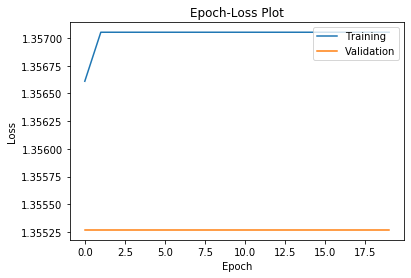

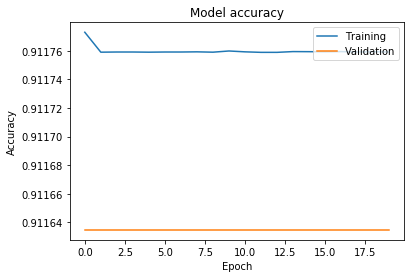

Test loss: 1.3525545804556656
Test accuracy: 0.9118121862411499


In [27]:
plotResults(CNN_multi_4_history)
modelAccuracy(CNN_multi_4, test_data_multi, test_label_multi)

This model also shows good results on all three different types of data. It reaches a very high accuracy quickly, but levels off at that point. Because of this behavior, this model may be inconsistent.

In [28]:
'''
Model 5
Uses the same layers as model 4, but with an adagrad optimizer
Only 2 dense layers but with a larger filter and kernal size in convolution layers
'''

CNN_multi_5 = models.Sequential()
CNN_multi_5.add(layers.Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=(7500,1)))
CNN_multi_5.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_5.add(layers.Conv1D(filters=16, kernel_size=8, activation='relu'))
CNN_multi_5.add(layers.Dropout(0.5))
CNN_multi_5.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_5.add(layers.Flatten())
CNN_multi_5.add(layers.Dense(50, activation='relu'))
CNN_multi_5.add(layers.Dense(22, activation='softmax'))
CNN_multi_5.compile(loss='categorical_crossentropy', optimizer= 'adagrad', metrics=['accuracy'])

In [29]:
CNN_multi_5_history = CNN_multi_5.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi, val_label_multi),
                   epochs=20, batch_size=128)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 490s 7ms/step - loss: 5.2174 - accuracy: 0.4418 - val_loss: 1.1482 - val_accuracy: 0.6637
Epoch 2/20
73980/73980 [==============================] - 489s 7ms/step - loss: 0.9950 - accuracy: 0.6854 - val_loss: 0.7730 - val_accuracy: 0.7674
Epoch 3/20
73980/73980 [==============================] - 490s 7ms/step - loss: 0.7503 - accuracy: 0.7587 - val_loss: 0.6382 - val_accuracy: 0.8120
Epoch 4/20
73980/73980 [==============================] - 488s 7ms/step - loss: 0.6225 - accuracy: 0.7974 - val_loss: 0.5493 - val_accuracy: 0.8407
Epoch 5/20
73980/73980 [==============================] - 489s 7ms/step - loss: 0.5433 - accuracy: 0.8235 - val_loss: 0.4897 - val_accuracy: 0.8512
Epoch 6/20
73980/73980 [==============================] - 490s 7ms/step - loss: 0.4739 - accuracy: 0.8444 - val_loss: 0.4633 - val_accuracy: 0.8648
Epoch 7/20
73980/73980 [==============================] - 488s

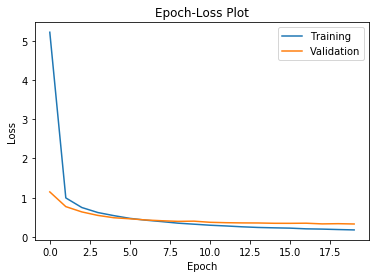

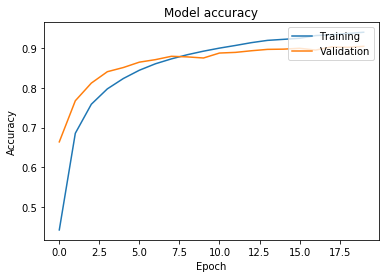

Test loss: 0.34639956838264757
Test accuracy: 0.8975263833999634


In [30]:
plotResults(CNN_multi_5_history)
modelAccuracy(CNN_multi_5, test_data_multi, test_label_multi)

Another great model that performs well on all three data sets. 

In [24]:
'''
Model 6
Further experimentation
Smaller filter and kernel sizes on the 1D convolutional layers
More dense layers of smaller sizes

'''

adagrad = keras.optimizers.Adagrad(lr=0.01)

CNN_multi_6 = models.Sequential()
CNN_multi_6.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu', input_shape=(7500,1)))
CNN_multi_6.add(layers.MaxPooling1D(pool_size=4))
CNN_multi_6.add(layers.Conv1D(filters=16, kernel_size=4, activation='relu'))
CNN_multi_6.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_6.add(layers.Dropout(0.5))
CNN_multi_6.add(layers.Conv1D(filters=8, kernel_size=2, activation='relu'))
CNN_multi_6.add(layers.MaxPooling1D(pool_size=2))
CNN_multi_6.add(layers.Flatten())
CNN_multi_6.add(layers.Dense(32, activation='relu'))
CNN_multi_6.add(layers.Dense(16, activation='relu'))
CNN_multi_6.add(layers.Dense(8, activation='relu'))
CNN_multi_6.add(layers.Dense(4, activation='relu'))
CNN_multi_6.add(layers.Dense(22, activation='softmax'))
CNN_multi_6.compile(loss='categorical_crossentropy', optimizer= 'adagrad', metrics=['accuracy'])

In [25]:
CNN_multi_6_history = CNN_multi_6.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi , val_label_multi),
                   epochs=20, batch_size=128)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 300s 4ms/step - loss: 2.9218 - accuracy: 0.1475 - val_loss: 2.8212 - val_accuracy: 0.1422
Epoch 2/20
73980/73980 [==============================] - 300s 4ms/step - loss: 2.7810 - accuracy: 0.1478 - val_loss: 2.7494 - val_accuracy: 0.1422
Epoch 3/20
73980/73980 [==============================] - 300s 4ms/step - loss: 2.7257 - accuracy: 0.1478 - val_loss: 2.7072 - val_accuracy: 0.1422
Epoch 4/20
73980/73980 [==============================] - 300s 4ms/step - loss: 2.6907 - accuracy: 0.1478 - val_loss: 2.6787 - val_accuracy: 0.1422
Epoch 5/20
73980/73980 [==============================] - 300s 4ms/step - loss: 2.6662 - accuracy: 0.1478 - val_loss: 2.6581 - val_accuracy: 0.1422
Epoch 6/20
73980/73980 [==============================] - 300s 4ms/step - loss: 2.6480 - accuracy: 0.1478 - val_loss: 2.6424 - val_accuracy: 0.1422
Epoch 7/20
73980/73980 [==============================] - 300s

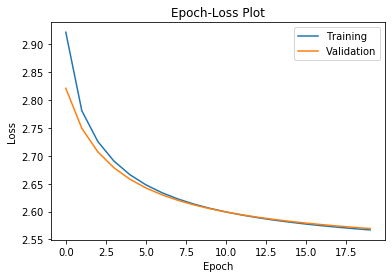

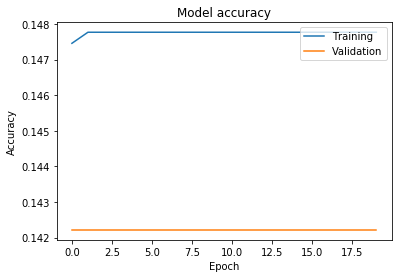

Test loss: 2.5718634696675817
Test accuracy: 0.1484590470790863


In [26]:
plotResults(CNN_multi_6_history)
modelAccuracy(CNN_multi_6, test_data_multi, test_label_multi)

This model reaches a similar point as the other failed models and is unable to get above around 14.5% accuracy.

In [ ]:
'''
#Code for saving the best model to a hard drive and printing out the more indepth and involved metrics

CNN_multi_6.summary()

keras.utils.plot_model(CNN_multi_7, show_layer_names=False, show_shapes=True, to_file='')

model_data = CNN_multi_7.to_json()

with open('filepath/model.json', 'w') as outputFile:
  outputFile.write(model_data)
  
CNN_multi_7.save_weights('filepath/modelWeight.h5')

with open('filepath/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(CNN_multi_7_history.history, file_pi)
  
model_history = CNN_multi_7_history.history

# Loading metrics from the model
with open('filepath/trainHistoryDict', 'rb') as f:
  new_model_history = pickle.load(f)
  
# Printing final numbers
model_metrics = new_model_history.keys()
for i in modelMetrics:
  print(i + ": {}".format(new_model_history[i][-1]))
  
plotResults(CNN_multi_7_history)
modelAccuracy(CNN_multi_7, test_data_multi, test_label_multi)
'''

This model combines a Long Short-Term Memory (LSTM) layer with the 1D CNN. It is unable to reach an adequate accuracy and quickly levels off. 

In [19]:
'''
Model 7
This is a model that combines CNN layers with LSTM layers
'''

from keras.optimizers import SGD
opt = SGD(lr=0.10)

LSTM_multi_1 = models.Sequential()
LSTM_multi_1.add(layers.Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=(7500,1)))
LSTM_multi_1.add(layers.MaxPooling1D(pool_size=2))
LSTM_multi_1.add(layers.Conv1D(filters=16, kernel_size=8, activation='relu'))
LSTM_multi_1.add(layers.MaxPooling1D(pool_size=2))
LSTM_multi_1.add(LSTM(10))
LSTM_multi_1.add(layers.Dense(22, activation='softmax'))
LSTM_multi_1.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

In [22]:
LSTM_multi_1_history = LSTM_multi_1.fit(train_data_multi, train_label_multi, 
                   validation_data=(val_data_multi ,val_label_multi),
                   epochs=20, batch_size=256)

Train on 73980 samples, validate on 24660 samples
Epoch 1/20
73980/73980 [==============================] - 667s 9ms/step - loss: 2.6592 - accuracy: 0.1464 - val_loss: 2.5785 - val_accuracy: 0.1422
Epoch 2/20
73980/73980 [==============================] - 664s 9ms/step - loss: 2.5570 - accuracy: 0.1478 - val_loss: 2.5487 - val_accuracy: 0.1422
Epoch 3/20
73980/73980 [==============================] - 714s 10ms/step - loss: 2.5385 - accuracy: 0.1478 - val_loss: 2.5375 - val_accuracy: 0.1422
Epoch 4/20
73980/73980 [==============================] - 649s 9ms/step - loss: 2.5301 - accuracy: 0.1478 - val_loss: 2.5313 - val_accuracy: 0.1422
Epoch 5/20
73980/73980 [==============================] - 641s 9ms/step - loss: 2.5252 - accuracy: 0.1478 - val_loss: 2.5273 - val_accuracy: 0.1422
Epoch 6/20
73980/73980 [==============================] - 639s 9ms/step - loss: 2.5220 - accuracy: 0.1478 - val_loss: 2.5247 - val_accuracy: 0.1422
Epoch 7/20
73980/73980 [==============================] - 641

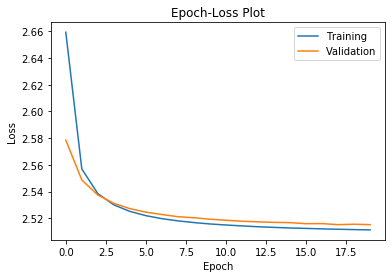

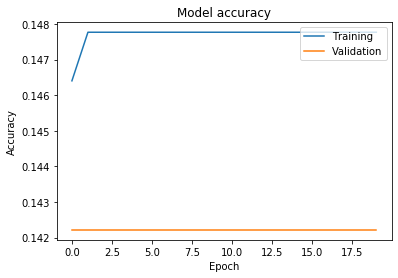

Test loss: 2.5173369812559327
Test accuracy: 0.1484590470790863


In [23]:
plotResults(LSTM_multi_1_history)
modelAccuracy(LSTM_multi_1, test_data_multi, test_label_multi)